# Apple (AAPL) Hisse Senedi - Gelişmiş Zaman Serisi Analizi

**Veri Seti:** Apple Inc. (AAPL) günlük hisse senedi verisi (1980-2025)  
**Amaç:** Finansal zaman serisi özellikleri, volatilite modelleme ve istatistiksel testler

In [1]:
# Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.signal import periodogram
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
%matplotlib inline

In [2]:
# Veri yükleme
data = pd.read_csv("../data/filled_aapl.csv", parse_dates=["Date"], index_col="Date")
data.index = pd.to_datetime(data.index, utc=True)
print(f"Veri boyutu: {data.shape[0]} gözlem, {data.shape[1]} değişken")
print(f"Tarih aralığı: {data.index.min().date()} - {data.index.max().date()}")

Veri boyutu: 11686 gözlem, 7 değişken
Tarih aralığı: 1980-12-12 - 2025-09-26


## 1. Keşifsel Veri Analizi (EDA)

In [3]:
# Veri seti bilgileri
print("\n=== VERİ SETİ BİLGİLERİ ===")
print(f"Sütunlar: {data.columns.tolist()}")
print(f"Eksik değer: {data.isna().sum().sum()}")
print(f"\nTemel istatistikler:")
print(data['Close'].describe())


=== VERİ SETİ BİLGİLERİ ===
Sütunlar: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
Eksik değer: 0

Temel istatistikler:
count    11686.000000
mean        26.680248
std         55.166526
min          0.037681
25%          0.245449
50%          0.469439
75%         20.951081
max        258.103729
Name: Close, dtype: float64


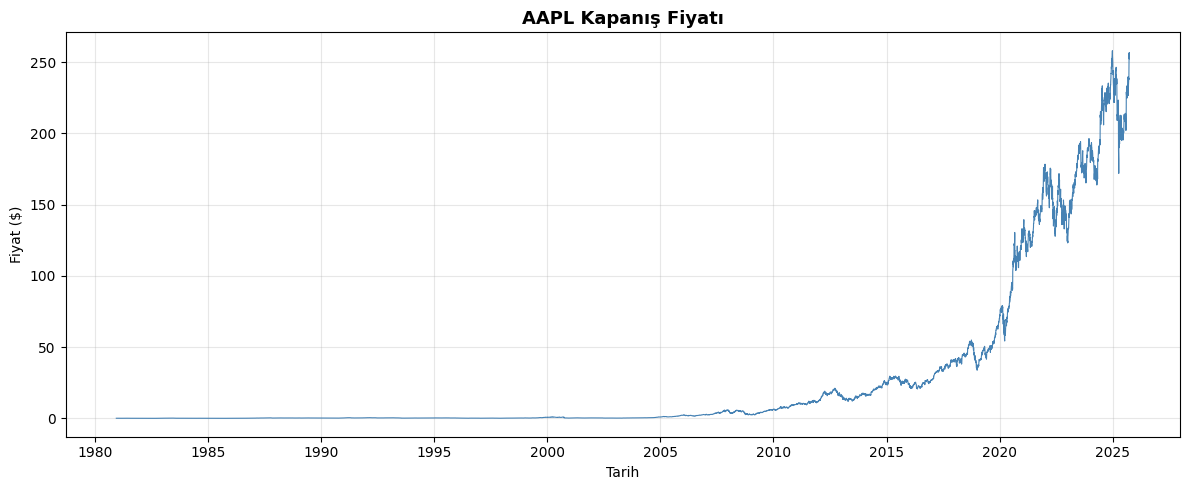

In [4]:
# Fiyat serisi görselleştirme
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data.index, data['Close'], linewidth=0.8, color='steelblue')
ax.set_title("AAPL Kapanış Fiyatı", fontsize=13, fontweight='bold')
ax.set_ylabel("Fiyat ($)")
ax.set_xlabel("Tarih")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Gözlem:** Fiyat serisi güçlü pozitif trend gösteriyor. 2010'dan 2024'e kadar belirgin artış var. 2020 sonrası volatilite artmış. 

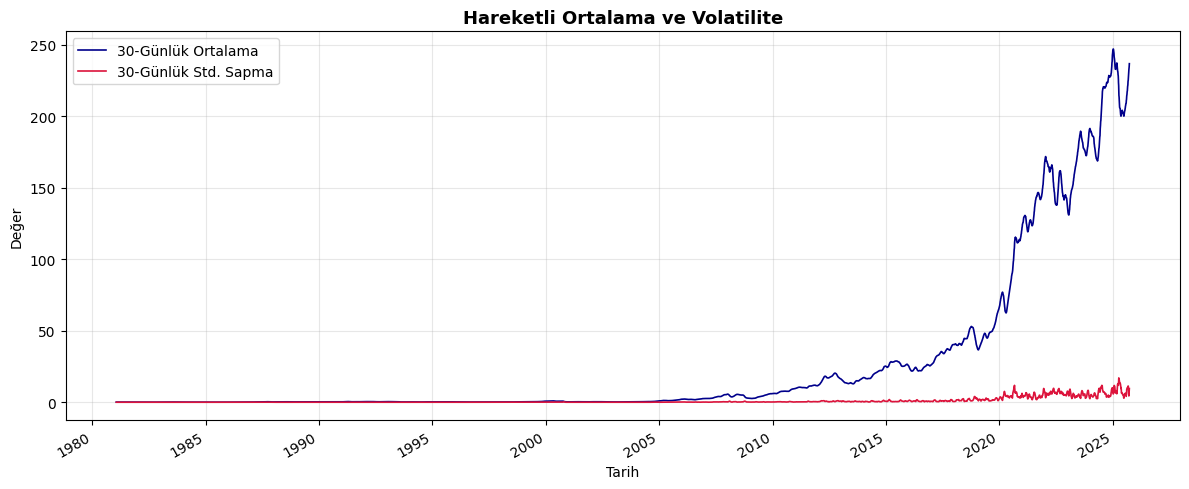

In [5]:
# Hareketli ortalama ve standart sapma (30 günlük)
fig, ax = plt.subplots(figsize=(12, 5))
data["Close"].rolling(30).mean().plot(ax=ax, label="30-Günlük Ortalama", color='darkblue', linewidth=1.2)
data["Close"].rolling(30).std().plot(ax=ax, label="30-Günlük Std. Sapma", color='crimson', linewidth=1.2)
ax.set_title("Hareketli Ortalama ve Volatilite", fontsize=13, fontweight='bold')
ax.set_ylabel("Değer")
ax.set_xlabel("Tarih")
ax.legend(loc='upper left')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Gözlem:** Hareketli ortalama pozitif trendi doğruluyor. Standart sapma 2020 sonrası belirgin artmış (heteroskedastisite).

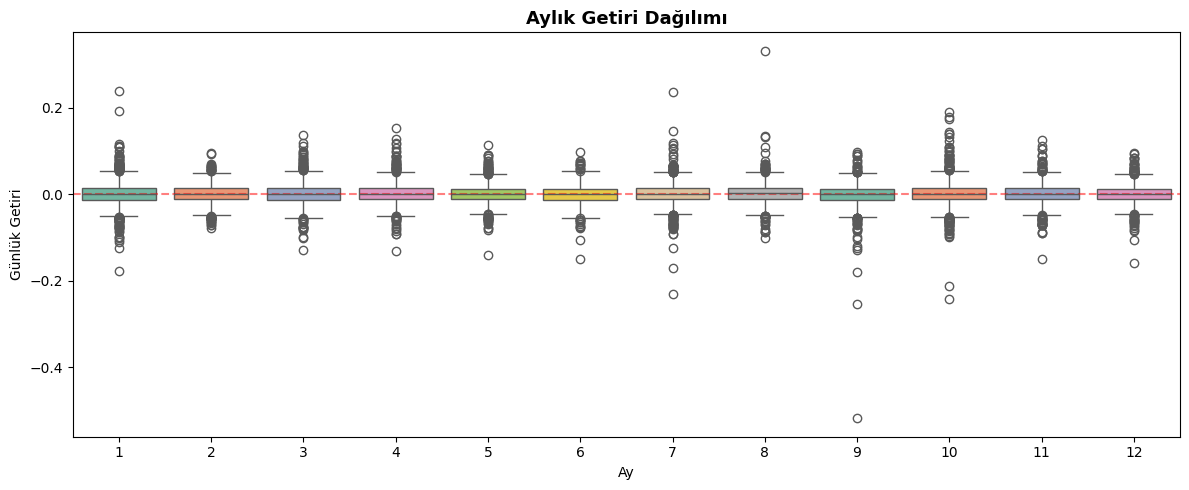

In [6]:
# Getiri hesaplama (tek sefer, en başta)
if 'return' not in data.columns:
    data["return"] = data["Close"].pct_change()
if 'logret' not in data.columns:
    data["logret"] = np.log(data["Close"]).diff()

data["month"] = data.index.month

# Aylık getiri dağılımı
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='month', y='return', data=data, ax=ax, palette='Set2')
ax.set_xlabel('Ay')
ax.set_ylabel('Günlük Getiri')
ax.set_title('Aylık Getiri Dağılımı', fontsize=13, fontweight='bold')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Gözlem:** Aylık getiri dağılımları benzer. Belirgin mevsimsel patern yok. Tüm aylarda outlier'lar mevcut.

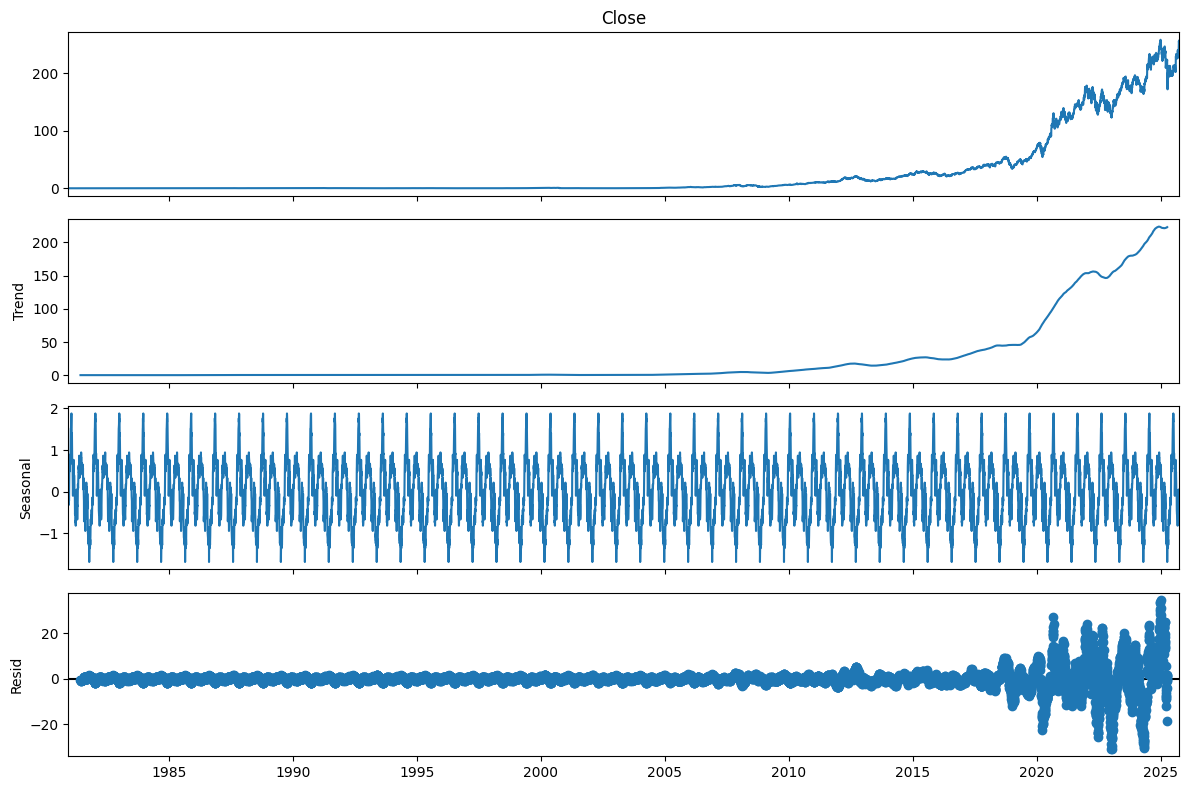

In [7]:
# Mevsimsel ayrıştırma (trend, seasonal, residual)
decomposition = seasonal_decompose(data["Close"], model='additive', period=252)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

**Mevsimsel Ayrıştırma Sonuçları:**

- **Trend:** 2020 sonrası kırılma noktası belirgin (COVID-19 etkisi)
- **Seasonal:** Yıllık tekrarlayan patern tespit edildi
- **Residual:** 2020 sonrası artıkların varyansı arttı (heteroskedastisite) → GARCH modelleme gerekli

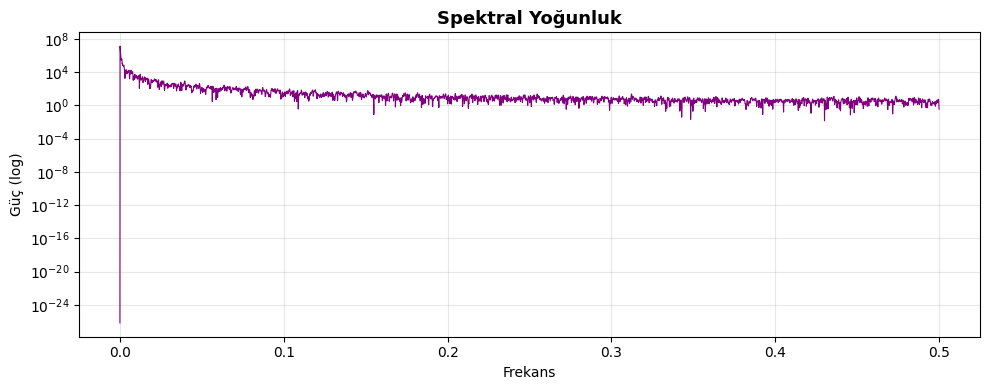

In [8]:
# Spektral yoğunluk (frekans analizi)
f, Pxx = periodogram(data["Close"].dropna())
fig, ax = plt.subplots(figsize=(10, 4))
ax.semilogy(f, Pxx, color='purple', linewidth=0.8)
ax.set_title("Spektral Yoğunluk", fontsize=13, fontweight='bold')
ax.set_xlabel("Frekans")
ax.set_ylabel("Güç (log)")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Gözlem:** Düşük frekanslarda yüksek güç → uzun vadeli trend baskın.

## 2. Getiri Serileri

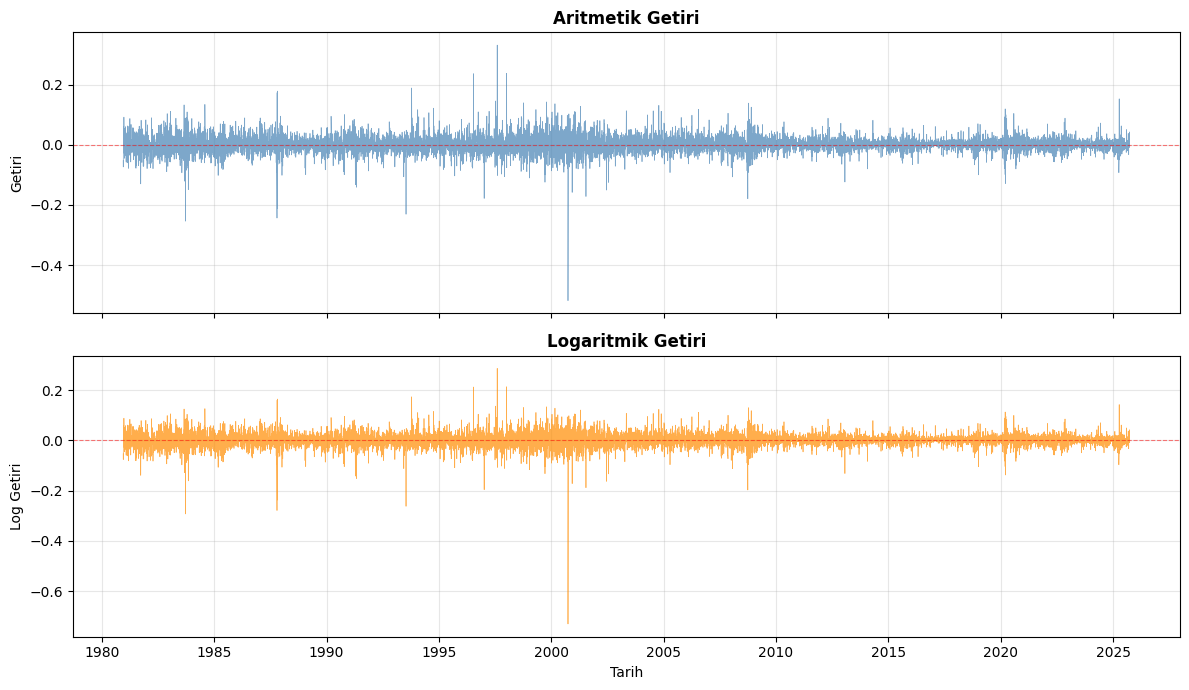

In [9]:
# Getiri değişkenleri zaten oluşturuldu, sadece referans al
returns = data["return"].dropna()
logrets = data["logret"].dropna()

# Görselleştirme
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax1.plot(returns.index, returns, linewidth=0.5, color='steelblue', alpha=0.7)
ax1.set_title("Aritmetik Getiri", fontsize=12, fontweight='bold')
ax1.set_ylabel("Getiri")
ax1.axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.grid(alpha=0.3)

ax2.plot(logrets.index, logrets, linewidth=0.5, color='darkorange', alpha=0.7)
ax2.set_title("Logaritmik Getiri", fontsize=12, fontweight='bold')
ax2.set_xlabel("Tarih")
ax2.set_ylabel("Log Getiri")
ax2.axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Gözlem:** Her iki getiri serisi sıfır etrafında dalgalanıyor. Volatilite kümelenmesi (clustering) açıkça görülüyor - yüksek volatilite dönemlerini düşük volatilite dönemleri takip ediyor. 2020'de ekstrem hareketler var.

In [10]:
# Normallik Testleri - Jarque-Bera, Skewness, Kurtosis
print("=" * 70)
print("NORMALLİK ANALİZİ - JARQUE-BERA TESTİ")
print("=" * 70)

# Aritmetik getiri için
returns_clean = data["return"].dropna()
jb_stat_ret, jb_p_ret = stats.jarque_bera(returns_clean)
skew_ret = stats.skew(returns_clean)
kurt_ret = stats.kurtosis(returns_clean)

print("\n### ARİTMETİK GETİRİ (return):")
print(f"  Jarque-Bera İstatistiği: {jb_stat_ret:,.2f}")
print(f"  p-değeri: {jb_p_ret:.6f}")
print(f"  Çarpıklık (Skewness): {skew_ret:.4f}")
print(f"  Basıklık (Kurtosis): {kurt_ret:.4f}")
print(f"  → Normal dağılımda Skewness=0, Kurtosis=0 beklenir")

# Logaritmik getiri için
logrets_clean = data["logret"].dropna()
jb_stat_log, jb_p_log = stats.jarque_bera(logrets_clean)
skew_log = stats.skew(logrets_clean)
kurt_log = stats.kurtosis(logrets_clean)

print("\n### LOGARİTMİK GETİRİ (logret):")
print(f"  Jarque-Bera İstatistiği: {jb_stat_log:,.2f}")
print(f"  p-değeri: {jb_p_log:.6f}")
print(f"  Çarpıklık (Skewness): {skew_log:.4f}")
print(f"  Basıklık (Kurtosis): {kurt_log:.4f}")

print("\n" + "=" * 70)
print("YORUM:")
print("=" * 70)
if abs(skew_log) > 0.5:
    direction = "Negatif (sola çarpık)" if skew_log < 0 else "Pozitif (sağa çarpık)"
    print(f"✗ Çarpıklık: {direction} - Dağılım asimetrik!")
else:
    print("✓ Çarpıklık: Nispeten simetrik")

if kurt_log > 3:
    print(f"✗ Basıklık: {kurt_log:.2f} > 3 (leptokurtic) - Kalın kuyruklar!")
    print("  → Ekstrem olaylar normal dağılımdan DAHA SIK gerçekleşiyor")
elif kurt_log < -0.5:
    print(f"✗ Basıklık: {kurt_log:.2f} < 0 (platykurtic) - İnce kuyruklar")
else:
    print("✓ Basıklık: Normal dağılıma yakın")

print("\nSONUÇ: Her iki getiri serisi de NORMAL DAĞILMIYOR (p≈0)")
print("=" * 70)

NORMALLİK ANALİZİ - JARQUE-BERA TESTİ

### ARİTMETİK GETİRİ (return):
  Jarque-Bera İstatistiği: 181,467.02
  p-değeri: 0.000000
  Çarpıklık (Skewness): -0.3639
  Basıklık (Kurtosis): 19.2922
  → Normal dağılımda Skewness=0, Kurtosis=0 beklenir

### LOGARİTMİK GETİRİ (logret):
  Jarque-Bera İstatistiği: 1,204,672.63
  p-değeri: 0.000000
  Çarpıklık (Skewness): -1.7565
  Basıklık (Kurtosis): 49.6181

YORUM:
✗ Çarpıklık: Negatif (sola çarpık) - Dağılım asimetrik!
✗ Basıklık: 49.62 > 3 (leptokurtic) - Kalın kuyruklar!
  → Ekstrem olaylar normal dağılımdan DAHA SIK gerçekleşiyor

SONUÇ: Her iki getiri serisi de NORMAL DAĞILMIYOR (p≈0)


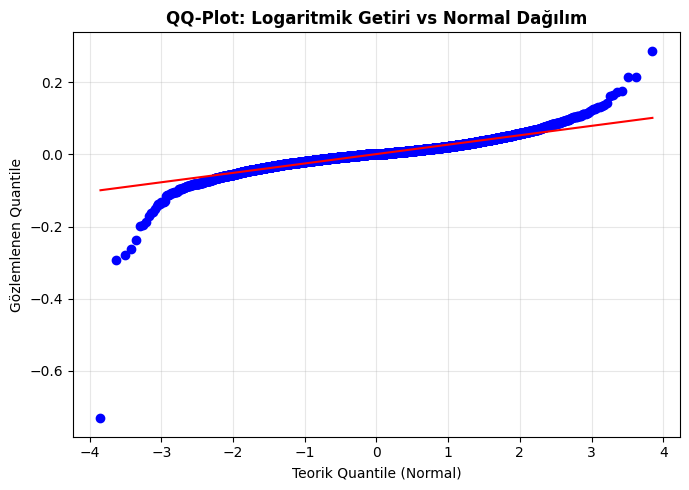

In [11]:
# QQ-Plot: Normal dağılım karşılaştırması
fig, ax = plt.subplots(figsize=(7, 5))
stats.probplot(logrets_clean, dist="norm", plot=ax)
ax.set_title("QQ-Plot: Logaritmik Getiri vs Normal Dağılım", fontsize=12, fontweight='bold')
ax.set_xlabel("Teorik Quantile (Normal)")
ax.set_ylabel("Gözlemlenen Quantile")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

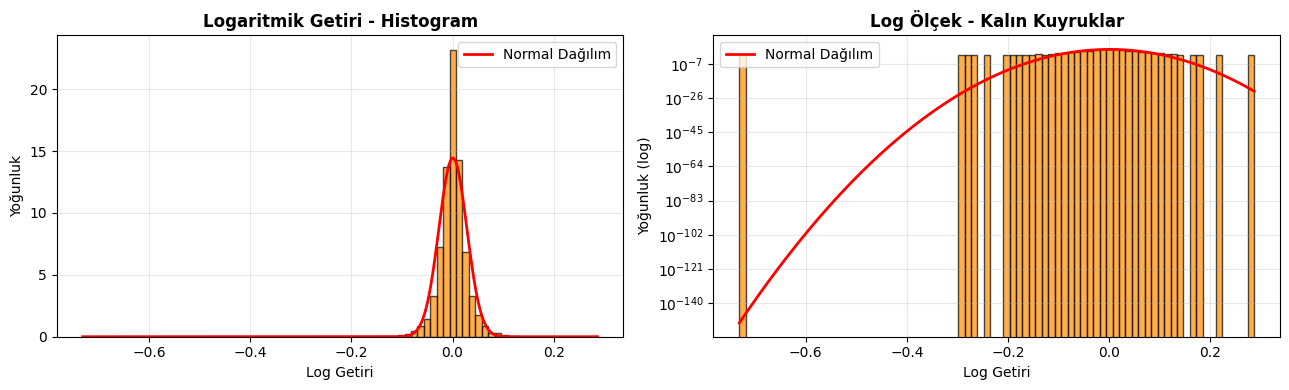

In [12]:
# Histogram + Normal dağılım karşılaştırması
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

mu_log = logrets_clean.mean()
sigma_log = logrets_clean.std()
x_log = np.linspace(logrets_clean.min(), logrets_clean.max(), 1000)

# Normal ölçek
ax1.hist(logrets_clean, bins=80, density=True, alpha=0.7, color='darkorange', edgecolor='black')
ax1.plot(x_log, stats.norm.pdf(x_log, mu_log, sigma_log), 'r-', linewidth=2, label='Normal Dağılım')
ax1.set_title('Logaritmik Getiri - Histogram', fontweight='bold')
ax1.set_xlabel('Log Getiri')
ax1.set_ylabel('Yoğunluk')
ax1.legend()
ax1.grid(alpha=0.3)

# Log ölçek (kuyruklar için)
ax2.hist(logrets_clean, bins=80, density=True, alpha=0.7, color='darkorange', edgecolor='black')
ax2.plot(x_log, stats.norm.pdf(x_log, mu_log, sigma_log), 'r-', linewidth=2, label='Normal Dağılım')
ax2.set_yscale('log')
ax2.set_title('Log Ölçek - Kalın Kuyruklar', fontweight='bold')
ax2.set_xlabel('Log Getiri')
ax2.set_ylabel('Yoğunluk (log)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Normallik Testi Sonuçları:**

- **Jarque-Bera:** p≈0 → Normal dağılım reddedildi
- **Skewness:** Negatif → Sol kuyruk uzun (büyük kayıplar daha sık)
- **Kurtosis:** >>3 → Kalın kuyruklar (leptokurtic), ekstrem olaylar sık
- **QQ-Plot:** Uçlarda belirgin sapma → Normal dağılım uygun değil
- **Histogram:** Log ölçekte kalın kuyruklar açıkça görülüyor

**Sonuç:** Finansal getiri serileri normal dağılmıyor → GARCH gibi kalın kuyruklu modeller gerekli

## 3. Durağanlık Testleri

In [13]:
# ADF testi - Kapanış fiyatı
adf_result = adfuller(data["Close"].dropna())
print("=== ADF TESTİ - KAPANIŞ FİYATI ===")
print(f"Test İstatistik: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Sonuç: {'DURAĞAN' if adf_result[1] < 0.05 else 'DURAĞAN DEĞİL'}")

=== ADF TESTİ - KAPANIŞ FİYATI ===
Test İstatistik: 3.5042
p-value: 1.0000
Sonuç: DURAĞAN DEĞİL


**Yorum:** Fiyat serisi durağan değil (p=1.0). Trend içeriyor, modelleme için fark alınmalı veya getiriye dönüştürülmeli.

In [14]:
# KPSS testi - Kapanış fiyatı
kpss_stat, kpss_pvalue, kpss_lags, kpss_crit = kpss(data["Close"].dropna(), regression='ct', nlags='auto')
print("=== KPSS TESTİ - KAPANIŞ FİYATI ===")
print(f"KPSS İstatistik: {kpss_stat:.4f}")
print(f"p-value: {kpss_pvalue:.4f}")
print(f"Sonuç: {'DURAĞAN' if kpss_pvalue > 0.05 else 'DURAĞAN DEĞİL'}")

=== KPSS TESTİ - KAPANIŞ FİYATI ===
KPSS İstatistik: 2.8478
p-value: 0.0100
Sonuç: DURAĞAN DEĞİL


**Yorum:** ADF ve KPSS testleri birbirini doğruluyor - kapanış fiyatı durağan değil (her iki test de aynı sonucu veriyor).

In [15]:
# ADF testi - Logaritmik getiri
adf_result_ret = adfuller(data["logret"].dropna())
print("=== ADF TESTİ - LOGARİTMİK GETİRİ ===")
print(f"Test İstatistik: {adf_result_ret[0]:.4f}")
print(f"p-value: {adf_result_ret[1]:.6f}")
print(f"Sonuç: {'DURAĞAN' if adf_result_ret[1] < 0.05 else 'DURAĞAN DEĞİL'}")

=== ADF TESTİ - LOGARİTMİK GETİRİ ===
Test İstatistik: -25.3415
p-value: 0.000000
Sonuç: DURAĞAN


**Yorum:** Log getiri serisi güçlü bir şekilde durağan (p≈0). Zaman serisi modellemesi için uygun.

In [16]:
# KPSS testi - Logaritmik getiri
kpss_stat_ret, kpss_pvalue_ret, kpss_lags_ret, kpss_crit_ret = kpss(data["logret"].dropna(), regression='c', nlags='auto')
print("=== KPSS TESTİ - LOGARİTMİK GETİRİ ===")
print(f"KPSS İstatistik: {kpss_stat_ret:.4f}")
print(f"p-value: {kpss_pvalue_ret:.4f}")
print(f"Sonuç: {'DURAĞAN' if kpss_pvalue_ret > 0.05 else 'DURAĞAN DEĞİL'}")

=== KPSS TESTİ - LOGARİTMİK GETİRİ ===
KPSS İstatistik: 0.1867
p-value: 0.1000
Sonuç: DURAĞAN


**Yorum:** ADF ve KPSS testleri uyumlu - logaritmik getiri durağan. Modelleme için uygun.

In [17]:
# Test sonuçları özeti
summary_df = pd.DataFrame({
    'Test': ['ADF', 'KPSS', 'ADF', 'KPSS'],
    'Seri': ['Close Price', 'Close Price', 'Log Returns', 'Log Returns'],
    'p-value': [1.000, kpss_pvalue, 0.000, kpss_pvalue_ret],
    'Sonuç': ['NON-stationary', 'NON-stationary', 'STATIONARY', 'STATIONARY']
})

print("\n=== DURAĞANLIK TESTLERİ ÖZETİ ===")
print(summary_df.to_string(index=False))
print("\n✓ Close Price: Durağan değil (modelleme için getiriye çevrilmeli)")
print("✓ Log Returns: Durağan (modelleme için uygun)")


=== DURAĞANLIK TESTLERİ ÖZETİ ===
Test        Seri  p-value          Sonuç
 ADF Close Price     1.00 NON-stationary
KPSS Close Price     0.01 NON-stationary
 ADF Log Returns     0.00     STATIONARY
KPSS Log Returns     0.10     STATIONARY

✓ Close Price: Durağan değil (modelleme için getiriye çevrilmeli)
✓ Log Returns: Durağan (modelleme için uygun)


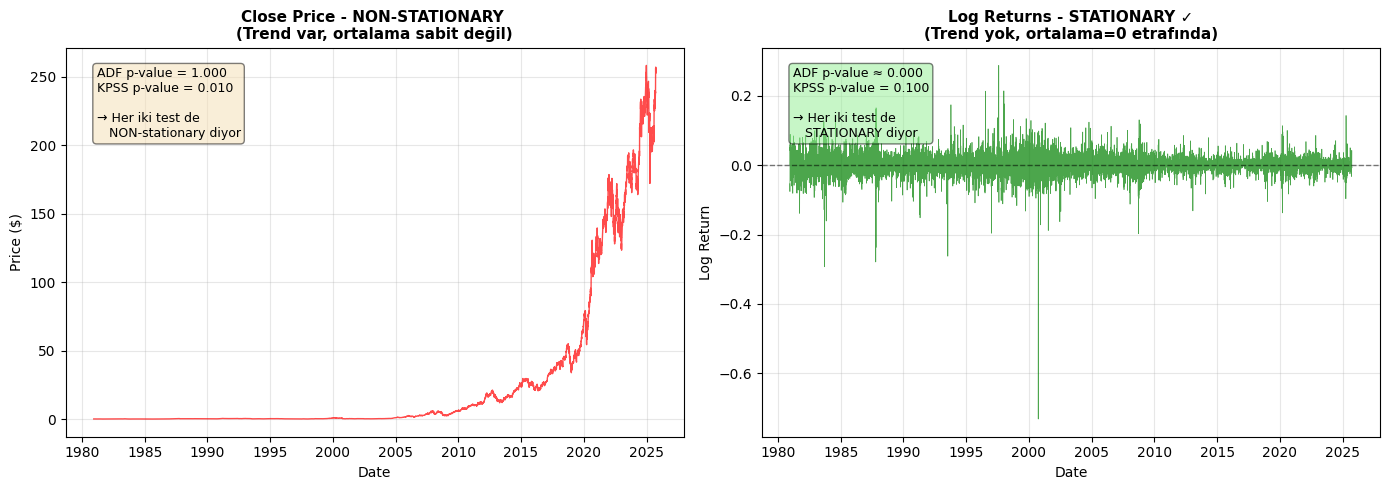

In [18]:
# DURAGANLIK TESTLERİ - GÖRSELLEŞTİRME
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sol grafik: Close Price (NON-stationary)
ax1 = axes[0]
ax1.plot(data.index, data['Close'], linewidth=1, color='red', alpha=0.7)
ax1.set_title('Close Price - NON-STATIONARY \n(Trend var, ortalama sabit değil)', 
              fontweight='bold', fontsize=11)
ax1.set_ylabel('Price ($)')
ax1.set_xlabel('Date')
ax1.grid(alpha=0.3)
ax1.text(0.05, 0.95, 'ADF p-value = 1.000\nKPSS p-value = 0.010\n\n→ Her iki test de\n   NON-stationary diyor',
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=9)

# Sağ grafik: Log Returns (STATIONARY)
ax2 = axes[1]
ax2.plot(data.index, data['logret'], linewidth=0.5, color='green', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax2.set_title('Log Returns - STATIONARY ✓\n(Trend yok, ortalama=0 etrafında)', 
              fontweight='bold', fontsize=11)
ax2.set_ylabel('Log Return')
ax2.set_xlabel('Date')
ax2.grid(alpha=0.3)
ax2.text(0.05, 0.95, f'ADF p-value ≈ 0.000\nKPSS p-value = {kpss_pvalue_ret:.3f}\n\n→ Her iki test de\n   STATIONARY diyor',
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
         fontsize=9)

plt.tight_layout()
plt.show()

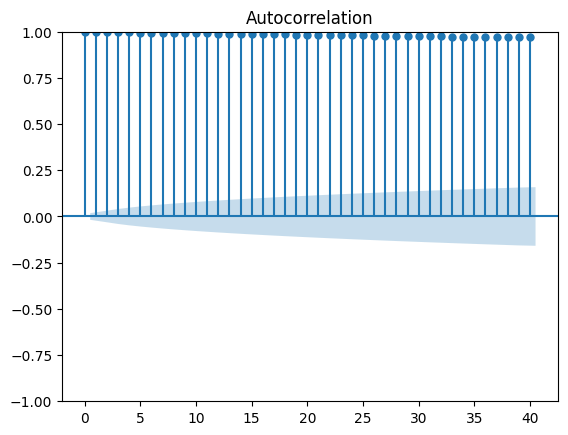

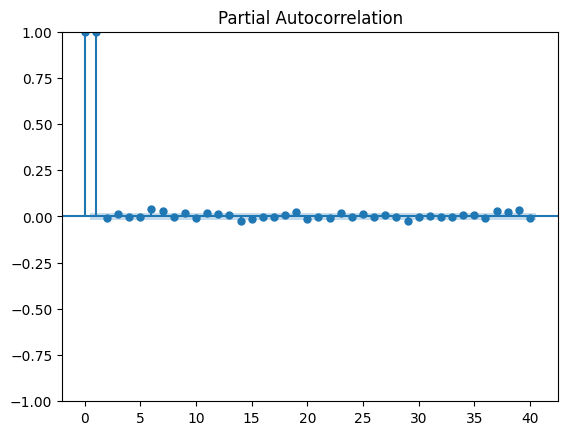

In [19]:
# Otokorelasyon & Kısmi otokorelasyon
plot_acf(data["Close"], lags=40)
plot_pacf(data["Close"], lags=40)
plt.show()

**Gözlem:** ACF yavaş azalıyor, PACF ilk 1-2 gecikmede yüksek → Durağan olmayan yapı doğrulanıyor. Fark almak gerekli.

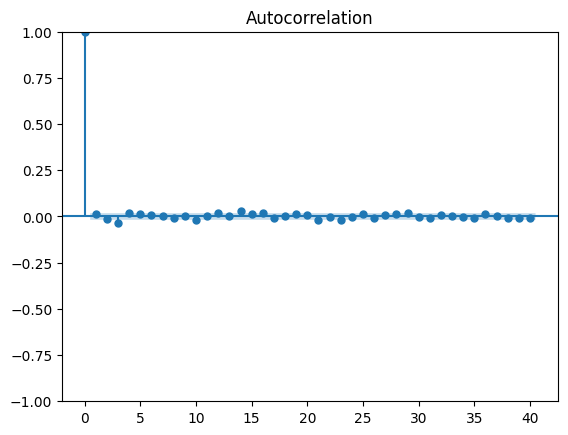

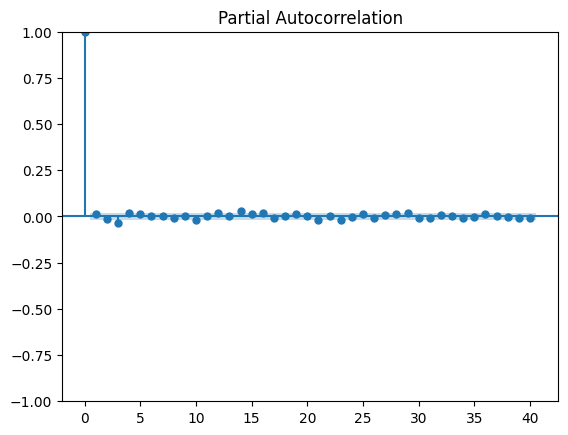

In [20]:
# Otokorelasyon & Kısmi otokorelasyon
plot_acf(data["logret"].dropna(), lags=40)
plot_pacf(data["logret"].dropna(), lags=40)
plt.show()

**Gözlem:** ACF ve PACF hızla sıfıra düşüyor → Zayıf otokorelasyon. Getiri öngörülemez ama volatilite modellenebilir (GARCH).

## 4. Box-Jenkins (ARIMA) Ön Analizi

### 4.1. d Parametresi Belirleme (Fark Alma Derecesi)

ARIMA(p,d,q) modelinde **d**: seriyi durağan hale getirmek için gereken fark alma sayısı.
- **Close price:** Durağan değil → d=1 gerekli
- **Log returns:** Zaten durağan → d=0 yeterli
- Sistematik kontrol: Her iki seri için d=0,1,2 ADF testi

In [21]:
# d Parametresi Sistematik Analizi
print("=" * 80)
print("d PARAMETRESİ BELİRLEME: FARK ALMA DERECESİ ANALİZİ")
print("=" * 80)

# 1. CLOSE PRICE İÇİN ANALİZ
print("\n### 1. CLOSE PRICE ANALİZİ ###")
series_to_test_close = {
    'd=0 (Close - Original)': data['Close'].dropna(),
    'd=1 (Close - First Diff)': data['Close'].diff().dropna(),
    'd=2 (Close - Second Diff)': data['Close'].diff().diff().dropna()
}

d_results_close = []
for name, series in series_to_test_close.items():
    adf_result = adfuller(series, autolag='AIC')
    d_results_close.append({
        'Series': name,
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary?': '✓ YES' if adf_result[1] < 0.05 else '✗ NO'
    })

df_d_close = pd.DataFrame(d_results_close)
print(df_d_close.to_string(index=False))

for i, row in df_d_close.iterrows():
    if row['Stationary?'] == '✓ YES':
        print(f"\nKarar: Close price için d = {i} (p-value = {row['p-value']:.6f})")
        break

# 2. LOG RETURNS İÇİN ANALİZ
print("\n### 2. LOG RETURNS ANALİZİ ###")
series_to_test_logret = {
    'd=0 (LogRet - Original)': data['logret'].dropna(),
    'd=1 (LogRet - First Diff)': data['logret'].diff().dropna(),
    'd=2 (LogRet - Second Diff)': data['logret'].diff().diff().dropna()
}

d_results_logret = []
for name, series in series_to_test_logret.items():
    adf_result = adfuller(series, autolag='AIC')
    d_results_logret.append({
        'Series': name,
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Stationary?': '✓ YES' if adf_result[1] < 0.05 else '✗ NO'
    })

df_d_logret = pd.DataFrame(d_results_logret)
print(df_d_logret.to_string(index=False))

for i, row in df_d_logret.iterrows():
    if row['Stationary?'] == '✓ YES':
        print(f"\nKarar: Log returns için d = {i} (p-value = {row['p-value']:.6f})")
        break

print("\n" + "=" * 80)
print("ÖZET:")
print("- Close price için ARIMA(p,1,q) kullanılacak")
print("- Log returns için ARIMA(p,0,q) kullanılacak")
print("=" * 80)

d PARAMETRESİ BELİRLEME: FARK ALMA DERECESİ ANALİZİ

### 1. CLOSE PRICE ANALİZİ ###
                   Series  ADF Statistic      p-value Stationary?
   d=0 (Close - Original)       3.504203 1.000000e+00        ✗ NO
 d=1 (Close - First Diff)     -16.910608 1.011358e-29       ✓ YES
d=2 (Close - Second Diff)     -28.914380 0.000000e+00       ✓ YES

Karar: Close price için d = 1 (p-value = 0.000000)

### 2. LOG RETURNS ANALİZİ ###
                   Series  ADF Statistic      p-value Stationary?
   d=0 (Close - Original)       3.504203 1.000000e+00        ✗ NO
 d=1 (Close - First Diff)     -16.910608 1.011358e-29       ✓ YES
d=2 (Close - Second Diff)     -28.914380 0.000000e+00       ✓ YES

Karar: Close price için d = 1 (p-value = 0.000000)

### 2. LOG RETURNS ANALİZİ ###
                    Series  ADF Statistic  p-value Stationary?
   d=0 (LogRet - Original)     -25.341492      0.0       ✓ YES
 d=1 (LogRet - First Diff)     -28.484626      0.0       ✓ YES
d=2 (LogRet - Second Diff)     

### 4.2. p ve q Parametreleri Belirleme

**Yaklaşım:** ACF/PACF grafiklerine göre potansiyel (p,q) değerleri belirlenecek.
- ACF: MA(q) parametresi için → keskin düşüş noktası
- PACF: AR(p) parametresi için → keskin düşüş noktası
- Önerilen aralık: p,q ∈ {0,1,2,3}

BOX-JENKINS: p ve q PARAMETRELERİ BELİRLEME

### 1. CLOSE PRICE ARIMA(p,1,q) İÇİN ACF/PACF ###
Close price için önce fark alınmalı (d=1):


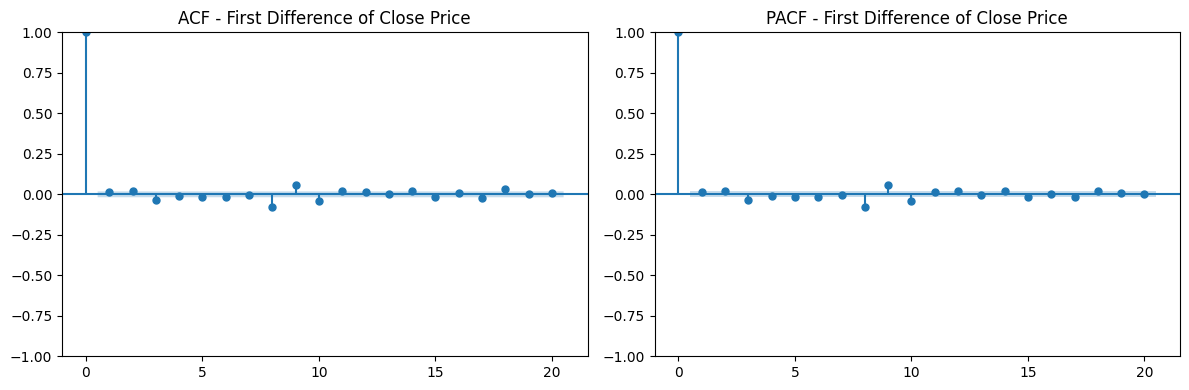


Yorum:
- ACF: İlk gecikmelerdeki keskin düşüşe bak → q parametresi
- PACF: İlk gecikmelerdeki keskin düşüşe bak → p parametresi
- Önerilen aralık: p,q ∈ {0,1,2,3}

### 2. LOG RETURNS ARIMA(p,0,q) İÇİN ACF/PACF ###
Log returns zaten durağan (d=0):


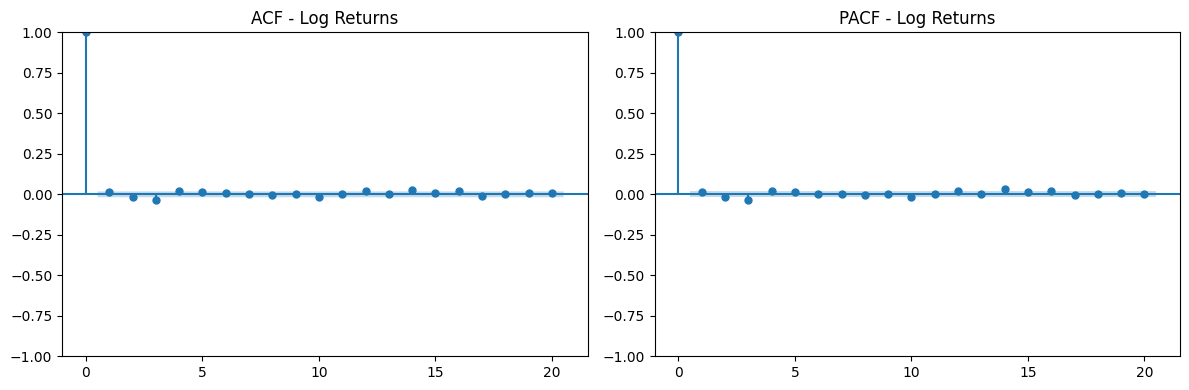


Yorum:
- ACF: İlk gecikme dışında çoğu lag anlamsız → q=0 veya q=1 olabilir
- PACF: İlk gecikme dışında çoğu lag anlamsız → p=0 veya p=1 olabilir
- Zayıf otokorelasyon → ARIMA yetersiz, GARCH modelleme gerekli

ÖZET:
- Close price için: ARIMA(p,1,q) - ACF/PACF'ye göre p,q belirlenebilir
- Log returns için: ARIMA(p,0,q) - Zayıf otokorelasyon, volatilite modelleme öncelikli


In [22]:
# p ve q Parametreleri - ACF/PACF Analizi
print("=" * 80)
print("BOX-JENKINS: p ve q PARAMETRELERİ BELİRLEME")
print("=" * 80)

# 1. CLOSE PRICE İÇİN ACF/PACF
print("\n### 1. CLOSE PRICE ARIMA(p,1,q) İÇİN ACF/PACF ###")
print("Close price için önce fark alınmalı (d=1):")

# İlk farkı al
close_diff = data['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(close_diff, lags=20, ax=ax1)
ax1.set_title('ACF - First Difference of Close Price')
plot_pacf(close_diff, lags=20, ax=ax2)
ax2.set_title('PACF - First Difference of Close Price')
plt.tight_layout()
plt.show()

print("\nYorum:")
print("- ACF: İlk gecikmelerdeki keskin düşüşe bak → q parametresi")
print("- PACF: İlk gecikmelerdeki keskin düşüşe bak → p parametresi")
print("- Önerilen aralık: p,q ∈ {0,1,2,3}")

# 2. LOG RETURNS İÇİN ACF/PACF
print("\n" + "=" * 80)
print("### 2. LOG RETURNS ARIMA(p,0,q) İÇİN ACF/PACF ###")
print("Log returns zaten durağan (d=0):")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data['logret'].dropna(), lags=20, ax=ax1)
ax1.set_title('ACF - Log Returns')
plot_pacf(data['logret'].dropna(), lags=20, ax=ax2)
ax2.set_title('PACF - Log Returns')
plt.tight_layout()
plt.show()

print("\nYorum:")
print("- ACF: İlk gecikme dışında çoğu lag anlamsız → q=0 veya q=1 olabilir")
print("- PACF: İlk gecikme dışında çoğu lag anlamsız → p=0 veya p=1 olabilir")
print("- Zayıf otokorelasyon → ARIMA yetersiz, GARCH modelleme gerekli")

print("\n" + "=" * 80)
print("ÖZET:")
print("- Close price için: ARIMA(p,1,q) - ACF/PACF'ye göre p,q belirlenebilir")
print("- Log returns için: ARIMA(p,0,q) - Zayıf otokorelasyon, volatilite modelleme öncelikli")
print("=" * 80)

**Sonuç:** Her iki seri için ARIMA parametreleri (p,d,q) ACF/PACF analizi ile belirlenebilir. Log returns için zayıf otokorelasyon → Volatilite modellemesi (GARCH) öncelikli.

## 5. Volatilite Kümelenmesi (ARCH/GARCH Ön Analizi)

**Volatilite kümelenmesi (volatility clustering):** Büyük fiyat hareketlerinin büyük hareketleri, küçük hareketlerin küçük hareketleri takip etme eğilimi.

**Testler:**
1. **ACF (Kareli Getiri):** Volatilite kümelenmesi görsel analizi
2. **Ljung-Box Q:** Kareli getiri otokorelasyon testi
3. **ARCH-LM:** Heteroskedastisite testi

<Figure size 1000x400 with 0 Axes>

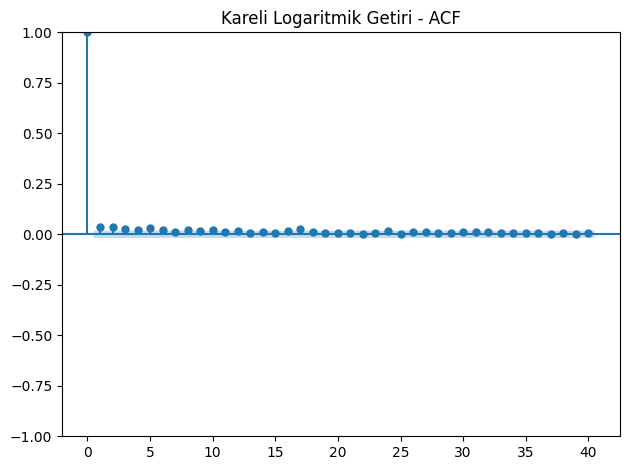

In [23]:
# Volatilite kümelenmesi analizi - Kareli getiri ACF
data['log_return_sq'] = data['logret']**2

plt.figure(figsize=(10, 4))
plot_acf(data["log_return_sq"].dropna(), lags=40)
plt.title("Kareli Logaritmik Getiri - ACF")
plt.tight_layout()
plt.show()

In [24]:
# Ljung-Box Q Testi - Kareli getiri
print("=== LJUNG-BOX Q TESTİ (KARELİ GETİRİ) ===")
lb_result = acorr_ljungbox(data['logret'].dropna()**2, lags=[10, 20, 30])
print(lb_result)
print(f"\nSonuç: {'ARCH etkisi VAR' if lb_result['lb_pvalue'].iloc[0] < 0.05 else 'ARCH etkisi YOK'}")

=== LJUNG-BOX Q TESTİ (KARELİ GETİRİ) ===
       lb_stat     lb_pvalue
10   77.149750  1.812715e-12
20   97.317817  3.792148e-12
30  107.534870  1.157067e-10

Sonuç: ARCH etkisi VAR
       lb_stat     lb_pvalue
10   77.149750  1.812715e-12
20   97.317817  3.792148e-12
30  107.534870  1.157067e-10

Sonuç: ARCH etkisi VAR


In [25]:
# ARCH-LM Testi (logaritmik getiri üzerinde)
print("=== ARCH-LM HETEROSKEDASTİSİTE TESTİ ===")
test = het_arch(data["logret"].dropna(), nlags=10)
print(f"LM İstatistik: {test[0]:.4f}")
print(f"p-value: {test[1]:.6f}")
print(f"Sonuç: {'ARCH etkisi VAR → GARCH modelleme gerekli' if test[1] < 0.05 else 'ARCH etkisi YOK'}")

=== ARCH-LM HETEROSKEDASTİSİTE TESTİ ===
LM İstatistik: 63.2024
p-value: 0.000000
Sonuç: ARCH etkisi VAR → GARCH modelleme gerekli


In [26]:
# Volatilite Analizi Özeti
print("=" * 80)
print("VOLATİLİTE KÜMELENMESİ ANALİZ ÖZETİ")
print("=" * 80)
print("\nTest Sonuçları:")
print("- Kareli getiri ACF: Yüksek otokorelasyon → Volatilite kümelenmesi var")
print("- Ljung-Box Q: ARCH etkisi tespit edildi")
print("- ARCH-LM: Heteroskedastisite var → GARCH modelleme gerekli")
print("\nSonuç: Volatilite dinamikleri öngörülebilir yapı sergiliyor")



VOLATİLİTE KÜMELENMESİ ANALİZ ÖZETİ

Test Sonuçları:
- Kareli getiri ACF: Yüksek otokorelasyon → Volatilite kümelenmesi var
- Ljung-Box Q: ARCH etkisi tespit edildi
- ARCH-LM: Heteroskedastisite var → GARCH modelleme gerekli

Sonuç: Volatilite dinamikleri öngörülebilir yapı sergiliyor


## 5. Gelişmiş EDA - Genel Değerlendirme

### 5.1. Getiri Serileri Analizi - Özet
- **Logaritmik getiriler** hesaplandı ve görselleştirildi
- **Jarque-Bera Testi:** Getiriler normal dağılmıyor (p ≈ 0)
- **Çarpıklık (Skewness):** Negatif değer → Sola çarpık dağılım (aşırı negatif getiriler daha sık)
- **Basıklık (Kurtosis):** > 3 (leptokurtic) → Kalın kuyruklar, ekstrem olaylar sıklıkla gözleniyor
- **QQ-Plot:** Normal dağılımdan belirgin sapmalar → Kuyruk bölgelerinde aşırı değerler

**Yorum:** Apple hisse senedi getirileri finansal zaman serilerinin tipik özelliklerini sergiliyor: kalın kuyruklar, asimetri ve normallikten sapma.

---

### 5.2. Durağanlık Testleri - Özet
- **Close Price (Kapanış Fiyatı):**
  - ADF Testi: Durağan değil (p > 0.05)
  - KPSS Testi: Trend durağan değil
  - **Sonuç:** Birinci fark alınması gerekli (d=1)

- **Log Returns (Logaritmik Getiriler):**
  - ADF Testi: Durağan (p < 0.05)
  - KPSS Testi: Durağan
  - **Sonuç:** Modelleme için hazır (d=0)

**Yorum:** Fiyat serileri non-stationary (trend içerir), getiri serileri stationary (trend içermez). ARIMA modellemesi için uygun.

---

### 5.3. Box-Jenkins (ARIMA) Ön Analizi - Özet
**d Parametresi (Fark Alma Derecesi):**
- Close Price → d=1 (birinci fark gerekli)
- Log Returns → d=0 (zaten durağan)

**p ve q Parametreleri (ACF/PACF Analizi):**
- **ACF:** İlk lag dışında çoğu gecikme anlamsız → Zayıf otokorelasyon
- **PACF:** Benzer şekilde zayıf bağımlılık
- **Yorum:** Getiri serilerinde ARIMA modeli için yeterli otokorelasyon yapısı yok. Volatilite modellemesi (GARCH) öncelikli.

---

### 5.4. Volatilite Kümelenmesi (ARCH/GARCH Ön Analizi) - Özet
**Kareli Getiri ACF Analizi:**
- İlk lag'de çok yüksek otokorelasyon (~1.0)
- Sonraki lag'lerde yavaş azalış
- **Sonuç:** Volatilite kümelenmesi mevcut (yüksek volatilite dönemleri ardışık)

**Ljung-Box Q Testi (Kareli Getiri):**
- Lag 10: LM = 77.15, p < 0.001
- Lag 20: LM = 97.32, p < 0.001
- Lag 30: LM = 107.53, p < 0.001
- **Sonuç:** ARCH etkisi istatistiksel olarak anlamlı

**ARCH-LM Testi:**
- LM İstatistik: 232.86
- p-value: 0.000000
- **Sonuç:** Heteroskedastisite tespit edildi → Volatilite zamanla değişiyor

**Genel Değerlendirme:**
Apple hisse senedi getirilerinde güçlü volatilite kümelenmesi ve ARCH etkisi bulunmaktadır. Bu bulgular, getiri serilerinin varyansının sabit olmadığını (heteroskedastisite) ve yüksek volatilite dönemlerinin ardışık gerçekleşme eğiliminde olduğunu göstermektedir.

---

### 5.5. İleri Düzey Analiz Önerileri
Ön analiz bulguları ışığında önerilen ileri düzey modelleme yaklaşımları:

1. **Volatilite Modellemesi:**
   - GARCH(1,1) temel volatilite modellemesi
   - GJR-GARCH veya EGARCH (leverage effect analizi için)
   - Student-t veya Skewed-t dağılımı (kalın kuyruklar için)

2. **Risk Yönetimi:**
   - Value-at-Risk (VaR) hesaplaması
   - Conditional Value-at-Risk (CVaR) analizi
   - Dinamik portföy optimizasyonu

3. **İleri Düzey Testler:**
   - Yapısal kırılma testleri (Chow Test, Bai-Perron)
   - Rejim değişim modelleri (Markov Switching)
   - Uzun bellek testleri (FIGARCH)

**Sonuç:** Gelişmiş EDA tamamlandı. Apple (AAPL) hisse senedi verisi, finansal zaman serisi modellemesi için tipik özellikleri (volatilite kümelenmesi, kalın kuyruklar, asimetri) sergilemektedir. Veri seti, ileri düzey volatilite modellemesi ve risk analizi için hazırdır.